# Data

Load data from NCH

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import pandas as pd


def forecast_long_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    # Quantile column mapping
    col_map = {
        0.025: "2.5 %",
        0.1: "10.0 %",
        0.25: "25.0 %",
        0.5: "50.0 %",
        0.75: "75.0 %",
        0.9: "90.0 %",
        0.975: "97.5 %",
    }

    # Pivot quantile rows
    q = df[df["type"] == "quantile"].copy()
    q["quantile"] = pd.to_numeric(q["quantile"])
    piv = (
        q[q["quantile"].isin(col_map)]
        .pivot(index="forecast_date", columns="quantile", values="value")
        .rename(columns=col_map)
    )

    # Add mean and sd (if present)
    res = piv.copy()
    for name in ["mean", "sd"]:
        m = (
            df[df["type"] == name][["forecast_date", "value"]]
            .drop_duplicates()
            .set_index("forecast_date")
            .rename(columns={"value": name})
        )
        res = res.join(m)

    # Set final column order and output
    cols = [
        "mean",
        "sd",
        "2.5 %",
        "10.0 %",
        "25.0 %",
        "50.0 %",
        "75.0 %",
        "90.0 %",
        "97.5 %",
    ]
    out = res[cols].reset_index().rename(columns={"forecast_date": "date"})
    return out

In [3]:
import os
from pathlib import Path
import shutil
import subprocess
import pandas as pd

# Define repository and local clone directory
repo_url = "https://github.com/KITmetricslab/hospitalization-nowcast-hub.git"
clone_dir = Path("/tmp/hospitalization-nowcast-hub")


def read_nch_model_submissions(model_dir: str) -> pd.DataFrame:
    csv_dir_path = clone_dir / model_dir
    csv_files = [
        csv_dir_path / file
        for file in os.listdir(csv_dir_path)
        if file.endswith(".csv")
    ]

    dfs = [
        pd.read_csv(file_path).assign(filename=file_path.name)
        for file_path in csv_files
    ]
    combined_df = pd.concat(dfs, ignore_index=True)
    query_string = "".join(
        """
    age_group == "00+" and target == "0 day ahead inc hosp" and location == "DE" 
    """.split(
            "\n"
        )
    )

    wide_df = forecast_long_to_wide(
        combined_df.query(query_string)[["forecast_date", "type", "quantile", "value"]]
    )

    wide_df["date"] = pd.to_datetime(wide_df["date"], format="%Y-%m-%d").dt.date

    return wide_df


if not clone_dir.exists():
    subprocess.run(
        ["git", "clone", "--depth", "1", repo_url, str(clone_dir)], check=True
    )

ilm_prop42_df = read_nch_model_submissions("data-processed_updated_models/ILM-prop42")
nch_ensemble_df = read_nch_model_submissions(
    "data-processed_updated_models/NowcastHub-MeanEnsemble40"
)

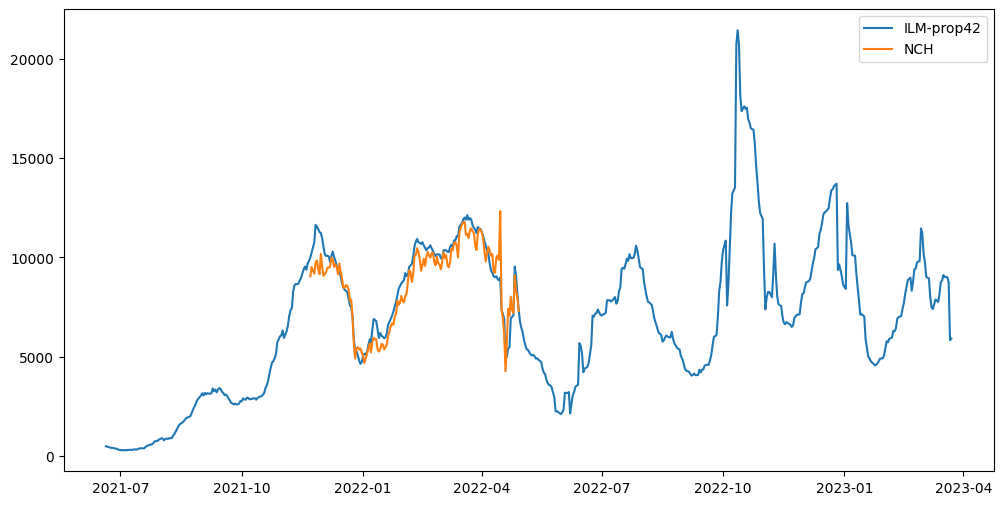

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(ilm_prop42_df["date"], ilm_prop42_df["mean"], label="ILM-prop42")
plt.plot(nch_ensemble_df["date"], nch_ensemble_df["mean"], label="NCH")
plt.legend()

plt.show()

In [9]:
from pyprojroot import here

ilm_prop42_df.to_csv(
    here("data/results/4_hospitalizations/nowcast/ilm_prop42.csv"), index=False
)
nch_ensemble_df.to_csv(
    here("data/results/4_hospitalizations/nowcast/nch_ensemble.csv"), index=False
)